# Problem statement

https://www.sciencedirect.com/science/article/pii/S0045782521000773

\begin{equation}
    \begin{aligned}
        \sigma_{ij,j}+b_i&=0\\
        \sigma_{ij}&=\lambda\delta_{ij}\varepsilon_{kk}+2\mu\varepsilon_{ij}\\
        \varepsilon_{ij}&=\frac{1}{2}\left(u_{i,j}+u_{j,i}\right)\\
        b_1&=\lambda\left(4\pi^2cos(2\pi x)sin(\pi y)-\pi cos(\pi x)\mathcal{Q}y^3\right)\\
        &+\mu\left(9\pi^2cos(2\pi x)sin(\pi y)-\pi cos(\pi x)\mathcal{Q}y^3\right)\\
        b_2&=\lambda\left(-3sin(\pi x)\mathcal{Q}y^2+2\pi^2sin(2\pi x)cos(\pi y)\right)\\
        &+\mu\left(-6sin(\pi x)\mathcal{Q}y^2+2\pi^2sin(2\pi x)cos(\pi y)\right)\\
        &+\mu\pi^2sin(\pi x)\mathcal{Q}y^4/4
    \end{aligned}
\end{equation}
where $\lambda=1$, $\mu=0.5$ and $\mathcal{Q}=4$

Pictorial representation of the problem set up and boundary conditions


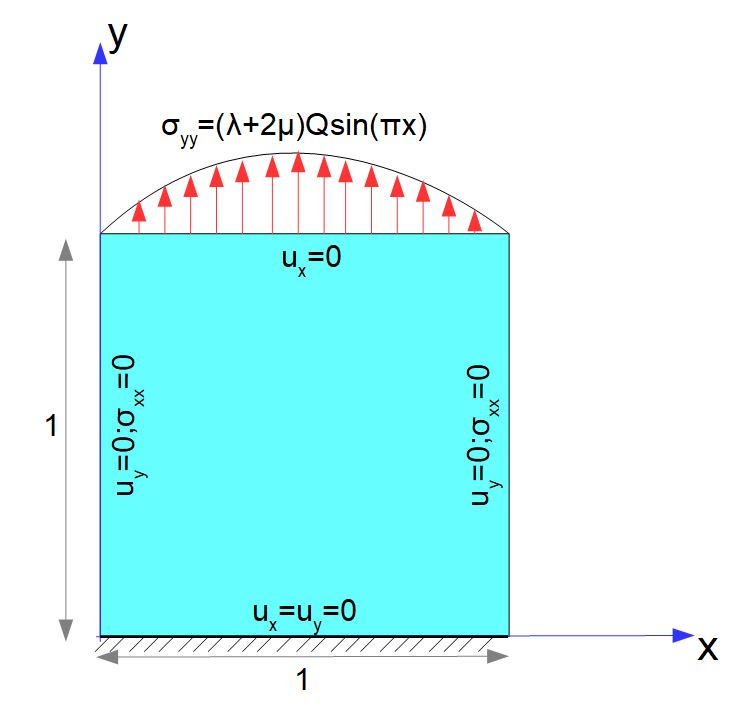

In [1]:
print("Pictorial representation of the problem set up and boundary conditions")
from IPython.display import Image
Image(filename='elastic.JPG', width = 250)

# imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
import FINDER_core

Using cuda device for FINDER


In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# Collocation points and boundary points

In [4]:
"""generating collocation points inside the domain"""
x = torch.linspace(0,1, steps = 100)
# x = x[1:-1]
y = torch.linspace(0,1, steps = 100)
# y = y[1:-1]
x,y = torch.meshgrid(x,y)
x = x.flatten()
y = y.flatten()
X_f_train = torch.vstack([x,y]).T.to(device)
del x,y
X_f_train.requires_grad_(True)
x = X_f_train[:,0].view(-1,1)
y = X_f_train[:,1].view(-1,1)

/home/uttam/miniforge3/envs/torch/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
"""generating boundary points"""
a = torch.linspace(0,1,100)
X_top = torch.vstack([a, torch.ones(100)]).T
X_bottom = torch.vstack([a, torch.zeros(100)]).T
X_left = torch.vstack([torch.zeros(100), a]).T
X_right = torch.vstack([torch.ones(100), a]).T

ux_bpts = torch.vstack([X_bottom, X_top]).to(device)
uy_bpts = torch.vstack([X_bottom, X_left, X_right]).to(device)
σ_xx_bpts = torch.vstack([X_left, X_right]).to(device)
σ_yy_bpts = X_top.to(device)

# PINN class

In [6]:
# constants as stated in the problem statement
lam = 1
mu = 0.5
Q = 4
pi = torch.pi
cos = torch.cos
sin = torch.sin

In [7]:
class ElasticityPINN(nn.Module):
    def __init__(self):
        super(ElasticityPINN, self).__init__()
        """create the neural networks"""
        self.create_net()
        
        """define loss criterion"""
        self.loss = nn.MSELoss()
        self.start = torch.nn.utils.parameters_to_vector(self.parameters()).to(device) # set same initial point to both optimizers
                                                         
        """allocating memory to variables to reduce load on garbage collection"""
        self.grads = torch.zeros_like(self.start) # gradients w.r.t model parameters
        self.null = torch.zeros_like(x) # to compute MSE loss
        
    def subnet(self):
        """returns a DNN"""
        return nn.Sequential(
            nn.Linear(2, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 1))

    def create_net(self):
        """ initializes the neural networks """
        self.net_ux = self.subnet() # DNN for displacement in x direction
        self.net_uy = self.subnet() # DNN for displacement in y direction
        self.net_σxx = self.subnet() # DNN for xx entry in stress tensor
        self.net_σxy = self.subnet() # DNN for xy entry in stress tensor
        self.net_σyy = self.subnet() # DNN for yy entry in stress tensor
    
    def net_all(self, X, num = 0):
        """returns networks predictions (n,2) -> (n,1)"""
        if num == 0:
            u_x = self.net_ux( X )
            u_y = self.net_uy( X )
            σ_xx = self.net_σxx( X )
            σ_xy = self.net_σxy( X )
            σ_yy = self.net_σyy( X )
            return u_x, u_y, σ_xx, σ_xy, σ_yy
        
        if num == 1:
            return self.net_ux( X )
        elif num == 2:
            return self.net_uy( X )
        elif num == 3:
            return self.net_σxx( X )
        elif num == 4:
            return self.net_σxy( X )
        elif num == 5:
            return self.net_σyy( X )

    
    def net_b(self):
        """returns the boundary loss"""
        self.u_x_b = self.net_all(ux_bpts, 1)
        self.u_y_b = self.net_all(uy_bpts, 2)
        self.σ_xx_b = self.net_all(σ_xx_bpts, 3)
        self.σ_yy_b = self.net_all(σ_yy_bpts, 5)
        
        self.σ_yy_actual = (lam + 2 * mu) * Q * torch.sin(pi * σ_yy_bpts[:,0:1])
        uxb_loss = self.loss(self.u_x_b, torch.zeros_like(self.u_x_b))
        uyb_loss = self.loss(self.u_y_b, torch.zeros_like(self.u_y_b))
        σxxb_loss = self.loss(self.σ_xx_b, torch.zeros_like(self.σ_xx_b))
        σyyb_loss = self.loss(self.σ_yy_b, self.σ_yy_actual)
        boundary_loss = uxb_loss + uyb_loss + σxxb_loss + σyyb_loss
        return boundary_loss

    
    def net_f(self):
        """returns the collocation loss"""
        X_f = torch.hstack([x,y])
        u_x, u_y, σ_xx, σ_xy, σ_yy = self.net_all(X_f)
        
        self.ϵ_x  = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0] # strain computation

        self.ϵ_y  = (torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True)[0] ) # strain computation

        self.ϵ_xy  = (0.5 * (
            torch.autograd.grad(
            u_x, y, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]  + 
            
            torch.autograd.grad(
            u_y, x,
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True)[0] 
        )) # strain computation
        
        self.dσxx_x  = (torch.autograd.grad(
            σ_xx, x, 
            grad_outputs=torch.ones_like(σ_xx),
            retain_graph=True,
            create_graph=True)[0] ) # divergence of stress tensor

        self.dσxy_y  = (torch.autograd.grad(
            σ_xy, y, 
            grad_outputs=torch.ones_like(σ_xy),
            retain_graph=True,
            create_graph=True)[0] ) # divergence of stress tensor

        self.dσyy_y  = (torch.autograd.grad(
            σ_yy, y, 
            grad_outputs=torch.ones_like(σ_yy),
            retain_graph=True,
            create_graph=True)[0] ) # divergence of stress tensor

        self.dσyx_x = (torch.autograd.grad(
            σ_xy, x,
            grad_outputs=torch.ones_like(σ_xy),
            retain_graph=True,
            create_graph=True)[0] ) # divergence of stress tensor

        # body force computation
        self.fx  = ((lam * (4 * pi**2 * cos(2*pi*x) * sin(pi*y) - pi * cos(pi*x) * Q * y**3)
              + mu * (9 * pi**2 * cos(2*pi*x) * sin(pi*y) - pi * cos(pi*x) * Q * y**3)) )
        self.fy  = ((lam * (-3 * sin(pi*x) * Q * y**2 + 2 * pi**2 * sin(2*pi*x) * cos(pi*y))
              + mu * (-6 * sin(pi*x) * Q * y**2 + 2 * pi**2 * sin(2*pi*x) * cos(pi*y) + pi**2 * sin(pi*x) * Q * (y**4)/4)) ) 
        
        # residue of governing equations
        eq1 = self.dσxx_x + self.dσxy_y + self.fx # force balance equation
        eq2 = self.dσyx_x + self.dσyy_y + self.fy # force balance equation
        eq3 = (lam + 2 * mu) * self.ϵ_x + lam * self.ϵ_y - σ_xx # constitutive relation
        eq4 = (lam + 2 * mu) * self.ϵ_y + lam * self.ϵ_x - σ_yy # constitutive relation
        eq5 = (2 * mu * self.ϵ_xy - σ_xy) # constitutive relation
        
        # loss computation
        eq1_loss = self.loss(eq1, self.null)
        eq2_loss = self.loss(eq2, self.null)
        eq3_loss = self.loss(eq3, self.null)
        eq4_loss = self.loss(eq4, self.null)
        eq5_loss = self.loss(eq5, self.null)
        
        colloc_loss = eq1_loss + eq2_loss + eq3_loss + eq4_loss + eq5_loss # total loss
        return colloc_loss

    def loss_grad(self, param, inputs = None, labels = None, no_grad = False):
        # setting the network parameters
        torch.nn.utils.vector_to_parameters(param, self.parameters())

        # zeroing the gradients
        self.zero_grad()


        if no_grad == False:        # if gradient is also required
            loss_b = self.net_b() # boundary loss
            loss_c = self.net_f() # collocation/residue loss
            self.ls = loss_b + loss_c
            
            # backward pass
            self.ls.backward()
            
            # assemble the gradients wrt model parameters
            self.grads[:] = torch.nn.utils.parameters_to_vector([param.grad for param in self.parameters()])
            
            return self.ls.detach().item(), self.grads

        else:        # if only loss is required then no backpropagation
            loss_c = self.net_f() # collocation/residue loss
            with torch.no_grad():
                loss_b = self.net_b() # boundary loss
                self.ls = loss_b + loss_c
                
                return self.ls.detach().item()

# model and optimizer

In [8]:
pinn = ElasticityPINN().to(device) # creating an object of class ElasticityPINN

In [9]:
FINDER = FINDER_core.FINDER(model = pinn, clamps = [0.001, 0.001]) # optimizer is set to be a of FINDER core class

In [10]:
# torch.nn.utils.vector_to_parameters(pinn_adam1.start, pinn.parameters())

In [11]:
print(pinn.start.shape[0]) # prints the count of model parameters

153505


# train with FINDER

In [12]:
every = 10
tic = time.time()
fx = []
pinn.train()
for epoch in range(10000):
    min_fitness_value = FINDER.step(inputs=None)
    fx.append(min_fitness_value)
    if (epoch) % every == 0:
        print('Epoch [%d] loss: %.6f' %(epoch, min_fitness_value))
    if min_fitness_value < 1e-2:
        break

toc = time.time()
print("finished training in: ", toc - tic, " seconds")


Epoch [0] loss: 2054.671875
Epoch [10] loss: 824.551758
Epoch [20] loss: 342.540466
Epoch [30] loss: 224.508850
Epoch [40] loss: 158.583298
Epoch [50] loss: 69.077255
Epoch [60] loss: 30.342037
Epoch [70] loss: 15.380999
Epoch [80] loss: 9.534025
Epoch [90] loss: 5.682173
Epoch [100] loss: 3.414549
Epoch [110] loss: 2.109905
Epoch [120] loss: 1.274889
Epoch [130] loss: 0.782500
Epoch [140] loss: 0.555945
Epoch [150] loss: 0.424048
Epoch [160] loss: 0.339971
Epoch [170] loss: 0.286162
Epoch [180] loss: 0.245018
Epoch [190] loss: 0.210018
Epoch [200] loss: 0.171811
Epoch [210] loss: 0.142760
Epoch [220] loss: 0.122041
Epoch [230] loss: 0.110077
Epoch [240] loss: 0.095667
Epoch [250] loss: 0.086219
Epoch [260] loss: 0.078019
Epoch [270] loss: 0.070272
Epoch [280] loss: 0.063956
Epoch [290] loss: 0.058399
Epoch [300] loss: 0.054059
Epoch [310] loss: 0.050885
Epoch [320] loss: 0.047880
Epoch [330] loss: 0.045371
Epoch [340] loss: 0.043180
Epoch [350] loss: 0.041160
Epoch [360] loss: 0.03950

In [16]:
torch.save(torch.tensor(fx), 'elasticity_FINDER_N153505.pt')

# train with Adam

In [25]:
pinn_adam1 = ElasticityPINN().to(device)


In [26]:
optimizer = torch.optim.Adam(pinn_adam1.parameters(), lr=0.001)  # Adjust learning rate as needed

In [27]:
# torch.nn.utils.vector_to_parameters(pinn.start, pinn_adam1.parameters()) # set same starting point for both optimizers

In [28]:
# Training loop
tic = time.time()
pinn_adam1.train()
fx_adam = []
for epoch in range(10000):  # Adjust number of epochs as needed
    running_loss = 0.0

    # Calculate loss
    loss_b = pinn_adam1.net_b()
    loss_c = pinn_adam1.net_f()
    loss = loss_b + loss_c

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    fx_adam.append(running_loss)

    if (epoch) % 10 == 0:  # Print loss every epoch
        print(f'Epoch [{epoch}] loss: {running_loss:.6f}')
    if running_loss < 1e-2:
        break
toc = time.time()
print("Finished training in:", toc - tic, "seconds")


Epoch [0] loss: 2079.138672
Epoch [10] loss: 2043.810303
Epoch [20] loss: 1984.195557
Epoch [30] loss: 1578.212524
Epoch [40] loss: 1137.437744
Epoch [50] loss: 849.776245
Epoch [60] loss: 505.674561
Epoch [70] loss: 380.380859
Epoch [80] loss: 315.439362
Epoch [90] loss: 269.948334
Epoch [100] loss: 220.797928
Epoch [110] loss: 176.300781
Epoch [120] loss: 129.470856
Epoch [130] loss: 83.327751
Epoch [140] loss: 52.850304
Epoch [150] loss: 39.245308
Epoch [160] loss: 30.097622
Epoch [170] loss: 25.271927
Epoch [180] loss: 21.564407
Epoch [190] loss: 18.072792
Epoch [200] loss: 14.890871
Epoch [210] loss: 12.231665
Epoch [220] loss: 10.111759
Epoch [230] loss: 8.529029
Epoch [240] loss: 7.442694
Epoch [250] loss: 6.693470
Epoch [260] loss: 5.909043
Epoch [270] loss: 5.324692
Epoch [280] loss: 4.835619
Epoch [290] loss: 4.413778
Epoch [300] loss: 4.047688
Epoch [310] loss: 3.737000
Epoch [320] loss: 4.040682
Epoch [330] loss: 3.255586
Epoch [340] loss: 3.079961
Epoch [350] loss: 2.79715

In [29]:
torch.save(torch.tensor(fx_adam), 'elasticity_adam_N153505.pt')

# testing

In [40]:
dx = 64
b = torch.linspace(0,1, steps = dx)
x0,y0 = torch.meshgrid(b,b)
x0 = x0.flatten()
y0 = y0.flatten()
X_f_test = torch.vstack([x0,y0]).T.to(device)

In [41]:
ux_pred = pinn.net_ux(X_f_test)
uy_pred = pinn.net_uy(X_f_test)
ux_actual = (torch.cos(2*torch.pi*X_f_test[:,0:1]) * torch.sin(torch.pi*X_f_test[:,1:2]))
uy_actual = torch.sin(torch.pi*X_f_test[:,0:1])*Q*(X_f_test[:,1:2]**4) / 4

In [42]:
ux_pred = ux_pred.reshape(dx,dx)
uy_pred = uy_pred.reshape(dx,dx)
ux_actual = ux_actual.reshape(dx,dx)
uy_actual = uy_actual.reshape(dx,dx)
ux_error = torch.abs(ux_pred - ux_actual)
uy_error = torch.abs(uy_pred - uy_actual)

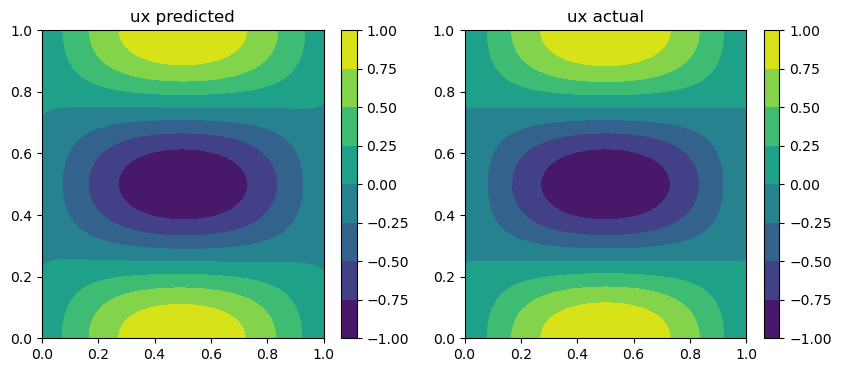

In [43]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first contour plot on the first subplot
cf1 = axs[0].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), ux_pred.cpu().detach().numpy())
axs[0].set_title('ux predicted')

# Plot the second contour plot on the second subplot
cf2 = axs[1].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), ux_actual.cpu().detach().numpy())
axs[1].set_title('ux actual')

# Add a color bar to each subplot
fig.colorbar(cf1, ax=axs[0])
fig.colorbar(cf2, ax=axs[1])

# Show the plot
plt.show()

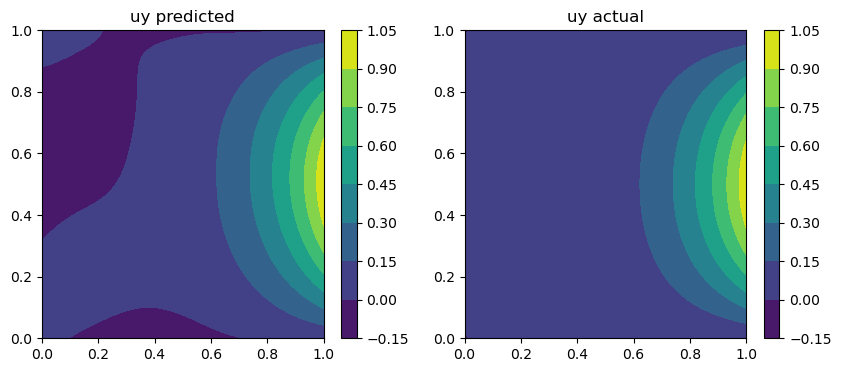

In [44]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first contour plot on the first subplot
cf1 = axs[0].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), uy_pred.cpu().detach().numpy())
axs[0].set_title('uy predicted')

# Plot the second contour plot on the second subplot
cf2 = axs[1].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), uy_actual.cpu().detach().numpy())
axs[1].set_title('uy actual')

# Add a color bar to each subplot
fig.colorbar(cf1, ax=axs[0])
fig.colorbar(cf2, ax=axs[1])

# Show the plot
plt.show()

# plotting

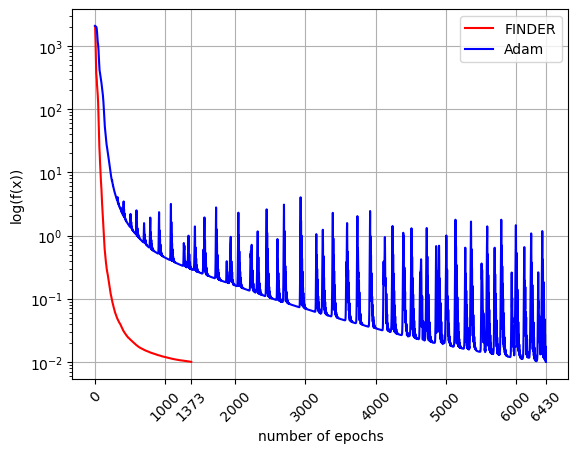

In [39]:
ax = plt.axes()
# ax.set_facecolor('bisque')
plt.plot(fx,'r', label = "FINDER")
plt.plot(fx_adam,'b', label = "Adam")
plt.xticks([0,1000,2000,3000,4000,5000,6000,len(fx), len(fx_adam)], rotation = 45)
plt.ylabel('log(f(x))')
plt.xlabel('number of epochs')
plt.legend()
plt.yscale('log')
plt.grid()